## NDA Coursework 2: Exploring patterns in edits to MP Wikipedia pages

Module code: 7CUSMNDA

Student number: 1887975

Made in Python 3.6

Contents:

<a href='#Packages and settings'>Packages and settings</a>

<a href='#Sources'>Sources</a>

<a href='#MP data curation and summary stats'>MP data curation and summary stats</a>

<a href='#Wiki MP edit data curation and summary stats'>Wiki MP edit data curation and summary stats</a>

<a href='#RQ1'>RQ1</a>

<a href='#RQ2'>RQ2</a>

<a href='#RQ3'>RQ3</a>

<a href='#RQ4'>RQ4</a>


## <a id="Packages and settings">Packages and settings<a/>

In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pysal as ps
import contextily as ctx
import sys
import scipy
import os
import re
import json
import networkx as nx
from copy import deepcopy
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Path, PathPatch
from matplotlib import cm
from itertools import count
from pysal import esda
from pysal.contrib.viz import mapping as viz
from pyproj import Proj, transform
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## <a id="Sources">Sources<a/>

In [5]:
wiki_edits = pd.read_csv("data/editHistoryMpUKConsti.csv")
MP_info1 = pd.read_csv("data/MPwikipedia.csv")
constit_bounds = gpd.read_file("data/constituencies.shp", crs={'init': 'epsg:27700'})
#Set CRS
constit_bounds = constit_bounds.to_crs(epsg=3857)

#Constituency hex map https://odileeds.org/projects/hexmaps/constituencies/
with open("data/constituencyhex.hexjson", 'r') as f:
        const_hex = json.load(f)

#Alternative source of party information: https://www.theyworkforyou.com/mps/
MP_info2 = pd.read_csv("data/mps.csv")

#Votor turnout from 2017: https://www.electoralcommission.org.uk/our-work/our-research/electoral-data/electoral-data-files-and-reports
election_2017 = pd.read_csv("data/2017 UKPGE electoral data 3.csv", encoding = "iso-8859-15", header=2, thousands=',')

## <a id="MP data curation and summary stats">MP data curation and summary stats<a/>

Found error in MPwikipedia.csv file provided for use in project!
All seats that changed parties in 2017 still have the party name from 2015 election (although the MP name is correct)

In [6]:
#Drop party column
MP_info1B = MP_info1.drop("Party",axis=1)

#Add the correct party info
MP_info2B = MP_info2[["Constituency", "Party"]]
MP_info3 = pd.merge(MP_info1B, MP_info2B, left_on="mpConstituency", right_on="Constituency").drop("Constituency", axis=1)

#Check missing MPs
set(MP_info1["MP Name"]) - set(MP_info3["MP Name"])

{'Albert Owen', 'Paul Flynn'}

In [7]:
#Add instances back in for two above MPS from original data set
#Confrimed on Parliament.uk party is correct
#Paul Flynn missing from Parliament.uk list as he passed away on 17th February 2019
#A bielection is scheduled for his Newport West seat on 9th April

MIS1 = MP_info1.loc[MP_info1["MP Name"] == "Albert Owen"]
MIS1 = MIS1[["MP Name", "mpConstituency", "MP Page Reference", "Party"]]

MIS2 = MP_info1.loc[MP_info1["MP Name"] == "Paul Flynn"]
MIS2 = MIS2[["MP Name", "mpConstituency", "MP Page Reference", "Party"]]


MP_info4 = pd.concat([MP_info3, MIS1, MIS2])

Checking the match of MP info and boundary constituency names and updating accordingly

In [8]:
#Check match of constituency names
set(MP_info4["mpConstituency"]) - set(constit_bounds["pcon17nm"])

{'Bury St Edmunds',
 'Holborn and St Pancras',
 'St Albans',
 'St Austell and Newquay',
 'St Helens North',
 'St Helens South and Whiston',
 'St Ives',
 'Ynys M�n'}

In [9]:
#As above
set(constit_bounds["pcon17nm"]) - set(MP_info4["mpConstituency"]) 

{'Bury St. Edmunds',
 'Holborn and St. Pancras',
 'St. Albans',
 'St. Austell and Newquay',
 'St. Helens North',
 'St. Helens South and Whiston',
 'St. Ives',
 'Ynys Mon'}

In [10]:
#Correct constituency in MP_info4 frame to be consistent with boundary shape file data 
MP_info4.loc[MP_info4["mpConstituency"] == 'Bury St Edmunds', "mpConstituency" ] = 'Bury St. Edmunds'
MP_info4.loc[MP_info4["mpConstituency"] == 'Holborn and St Pancras', "mpConstituency" ] = 'Holborn and St. Pancras'
MP_info4.loc[MP_info4["mpConstituency"] == 'St Albans', "mpConstituency" ] = 'St. Albans'
MP_info4.loc[MP_info4["mpConstituency"] == 'St Austell and Newquay', "mpConstituency" ] = 'St. Austell and Newquay'
MP_info4.loc[MP_info4["mpConstituency"] == 'St Helens North', "mpConstituency" ] = 'St. Helens North'
MP_info4.loc[MP_info4["mpConstituency"] == 'St Helens South and Whiston', "mpConstituency" ] = 'St. Helens South and Whiston'
MP_info4.loc[MP_info4["mpConstituency"] == 'St Ives', "mpConstituency" ] = 'St. Ives'
MP_info4.loc[MP_info4["mpConstituency"] == 'Ynys M�n', "mpConstituency" ] = 'Ynys Mon'

Creating extra column in MP info data to allow merge with edit data

In [11]:
#Define function to extract mp name with underscore b/n
#...first and surname from main data set (remove /wiki/)
def ext_name(pageref):
    ref = pageref[6:]
    return ref

#Apply function to MP Page Reference column
MP_info4["mp"] = MP_info4["MP Page Reference"].apply(ext_name)
MP_info4

MP Name                               mpConstituency  \
0     The Hon. Stephen Kinnock                                     Aberavon   
1                    Guto Bebb                                    Aberconwy   
2              Kirsty Blackman                               Aberdeen North   
3                 Ross Thomson                               Aberdeen South   
4                    Neil Gray                           Airdrie and Shotts   
5                 Leo Docherty                                    Aldershot   
6                 Wendy Morton                          Aldridge-Brownhills   
7                 Graham Brady                     Altrincham and Sale West   
8                    Mark Tami                             Alyn and Deeside   
9                  Nigel Mills                                 Amber Valley   
10               Kirstene Hair                                        Angus   
11              Hywel Williams                                        Arfon   
12              Brendan O'Hara                              Argyll and Bute   
13                Nick Herbert                      Arundel and South Downs   
14             Gloria De Piero                                     Ashfield   
15                Damian Green                                      Ashford   
16               Angela Rayner                            Ashton-under-Lyne   
17             David Lidington                                    Aylesbury   
18                  Bill Grant                     Ayr, Carrick and Cumnock   
19   The Hon. Victoria Prentis                                      Banbury   
20                David Duguid                             Banff and Buchan   
21         Dame Margaret Hodge                                      Barking   
22                  Dan Jarvis                             Barnsley Central   
23           Stephanie Peacock                                Barnsley East   
24               John Woodcock                           Barrow and Furness   
25                  John Baron                      Basildon and Billericay   
26                Maria Miller                                  Basingstoke   
27                   John Mann                                    Bassetlaw   
28               Wera Hobhouse                                         Bath   
29                Tracy Brabin                              Batley and Spen   
30           Marsha de Cordova                                    Battersea   
31              Dominic Grieve                                 Beaconsfield   
32                 Bob Stewart                                    Beckenham   
33              Mohammad Yasin                                      Bedford   
34              Gavin Robinson                                 Belfast East   
35                 Nigel Dodds                                Belfast North   
36        Emma Little Pengelly                                Belfast South   
37                 Paul Maskey                                 Belfast West   
38                  Neil Coyle                 Bermondsey and Old Southwark   
39        Anne-Marie Trevelyan                           Berwick-upon-Tweed   
40                 John Lamont           Berwickshire, Roxburgh and Selkirk   
41               Rushanara Ali                        Bethnal Green and Bow   
42               Graham Stuart                      Beverley and Holderness   
43                Huw Merriman                           Bexhill and Battle   
44              David Evennett                     Bexleyheath and Crayford   
45                 Frank Field                                   Birkenhead   
46                  Preet Gill                        Birmingham, Edgbaston   
47                 Jack Dromey                        Birmingham, Erdington   
48               Roger Godsiff                       Birmingham, Hall Green   
49                  Liam Byrne                       Birmingham, Hodge Hi

## <a id="Wiki MP edit data curation and summary stats">Wiki MP edit data curation and summary stats<a/>

In [12]:
#Code resued from NDA CW1

#Subset columns of interest from main data
wiki_edits2 = wiki_edits[["Timestamp", "User", "Page.Size", "Delta", "Comment", "mp", "Constituency", "Constituency.Code" ]]

#Merge wiki_edits frame with MP_info fame
wiki_edits_3 = pd.merge(wiki_edits2, MP_info4, how = "left")

#Create column showing if the constituency of edit matches constituency of MP
wiki_edits_3['MATCH'] = np.where(wiki_edits_3['Constituency']==wiki_edits_3['mpConstituency'], 1, 0)

#Function to extract sign of delta column
def extract_delta(texty):
    text = re.findall(r'[+](?=\d+)|[-](?=\d+)|(?<=[(])[0]', texty)
    return text[0]

wiki_edits_3["reversion"] = wiki_edits_3["Delta"].apply(extract_delta)

#1 if a revert 0 otherwise
wiki_edits_3["reversion"] = np.where(wiki_edits_3["reversion"] =="-", 1, 0)

#Change timestamp to datetime
wiki_edits_3.Timestamp = pd.to_datetime(wiki_edits_3.Timestamp)

#Rename columns
wiki_edits_4 = wiki_edits_3.rename(columns = {"Constituency":'EditorConstituency', "Constituency.Code":'EditorConstituencyCode'}) 

In [13]:
#Create new frame with edits only made during this Parliament
wiki_edits_4B = wiki_edits_4.loc[wiki_edits_4.Timestamp > pd.to_datetime("2017-06-10 00:00:00")]

In [14]:
#Total number of edits
len(wiki_edits_4)

38983

In [15]:
#Number of edita during this Parliament
len(wiki_edits_4B)

4190

In [16]:
#Check no edits without IP address
wiki_edits_4.User.isnull().unique()

array([False])

In [17]:
#Number of edits without an IP address that could be geocoded
wiki_edits_4["WithoutGeo"] = wiki_edits_4["EditorConstituencyCode"].isnull()
len(wiki_edits_4.loc[wiki_edits_4["WithoutGeo"] == True])

5557

In [18]:
#Proportion not geocoded
5557/39883

0.13933254770202844

In [19]:
len(wiki_edits_4) - len(wiki_edits_4B)

34793

## <a id="RQ1">RQ1<a/>

In [20]:
#MP aggregates
MP_agg = pd.DataFrame(wiki_edits_4.groupby(by=["mpConstituency", "mp", "Party"]).count())

#Delta column populated from previous step with edit count
MP_agg2 =pd.DataFrame(MP_agg["Delta"].sort_values(ascending=False))
MP_agg2.columns = ["Edit_count"]
mp_agg2 = MP_agg2.reset_index()
mp_agg2

mpConstituency  \
0                     Uxbridge and South Ruislip   
1                                Doncaster North   
2                         Camberwell and Peckham   
3                                   Surrey Heath   
4                   Chingford and Woodford Green   
5                                     Maidenhead   
6              Hackney North and Stoke Newington   
7                                     Twickenham   
8                                     Buckingham   
9                                       Bolsover   
10                               Welwyn Hatfield   
11                                 Richmond Park   
12                               Islington North   
13                                North Somerset   
14                                   Derby South   
15                                    Rushcliffe   
16                           North East Somerset   
17                                     Streatham   
18                         Preseli Pembrokeshire   
19                              Mid Bedfordshire   
20                                        Tatton   
21                                Leicester East   
22                        Haltemprice and Howden   
23                  Islington South and Finsbury   
24                              Hastings and Rye   
25          Normanton, Pontefract and Castleford   
26                               Epsom and Ewell   
27                                    Don Valley   
28                                Wellingborough   
29                                   West Dorset   
30                      Westmorland and Lonsdale   
31                                 Leeds Central   
32                                       Romford   
33                                 Brent Central   
34                                       Shipley   
35                       Runnymede and Weybridge   
36                          Liverpool, Wavertree   
37                            West Bromwich East   
38                                Leicester West   
39                                     Tottenham   
40                        South Northamptonshire   
41                                       Barking   
42                            Rutland and Melton   
43                                     Bassetlaw   
44                              Ealing, Southall   
45                                 Belfast North   
46                                    Leeds West   
47                                       Rhondda   
48                            Brighton, Pavilion   
49                                       Ashford   
50                                 Enfield North   
51                        Penrith and The Border   
52                                     Guildford   
53                              Sutton Coldfield   
54                              East Londonderry   
55                                   East Antrim   
56                                    Bromsgrove   
57                                      Broxtowe   
58                                        Witham   
59                                         Dover   
60                                      Vauxhall   
61                                      Wallasey   
62                         Kingston and Surbiton   
63                           Orkney and Shetland   
64                                 Croydon South   
65                           East Dunbartonshire   
66                                     Wokingham   
67                                        Putney   
68                                        Maldon   
69                    East Worthing and Shoreham   
70                              North Shropshire   
71                                      Monmouth   
72                                 Southend West   
73                                    Mid Sussex   
74                                        Exeter   
75                                       Devizes   
76                            

In [21]:
#Create dataframe with party shares
party_agg = MP_agg.groupby(by="Party").sum().apply(lambda g: g / g.sum())

#Used time stamp could have selected any column
party_agg2 = pd.DataFrame(party_agg.Timestamp)

#party rather than party column that aggregates smaller parties together
party_agg2["party"] = np.array(["Conservative", "Other", "Other", "Independent", "Labour", "Labour", "Lib Dem", "Other", "SNP" , "Other" ,"Other"])

party_agg2 = party_agg2.groupby("party").sum()

#Rename column
party_agg2.columns = ["Share of edits all time"]
party_agg2

Share of edits all time
party                                
Conservative                 0.513737
Independent                  0.040556
Labour                       0.355899
Lib Dem                      0.032399
Other                        0.040813
SNP                          0.016597

In [22]:
#MP edits since 2017 General Election
MP_aggb = pd.DataFrame(wiki_edits_4B.groupby(by=["mpConstituency", "mp", "Party"]).count())

#Delta column populated from previous step with edit count
MP_agg2b =pd.DataFrame(MP_aggb["Delta"].sort_values(ascending=False))
MP_agg2b.columns = ["Edit_count"]
mp_agg2b = MP_agg2b.reset_index()
mp_agg2b

mpConstituency  \
0                          North East Somerset   
1                        Preseli Pembrokeshire   
2                                 Newton Abbot   
3                                      Ashford   
4                                   Kensington   
5                                        Dover   
6                           Glasgow North East   
7                             Portsmouth North   
8                          South Staffordshire   
9                                 Surrey Heath   
10                                      Tatton   
11           Hackney North and Stoke Newington   
12                               Croydon South   
13                            Hastings and Rye   
14                                   Sevenoaks   
15                           North West Durham   
16                                  Twickenham   
17                           Sheffield, Hallam   
18                                    Bolsover   
19                      Haltemprice and Howden   
20                                      Witham   
21                    Westmorland and Lonsdale   
22                                      Putney   
23                                  Bromsgrove   
24                          Berwick-upon-Tweed   
25                                   Mansfield   
26                            East Londonderry   
27                       North East Derbyshire   
28                                    Broxtowe   
29                                       Moray   
30                                   Orpington   
31                Islington South and Finsbury   
32                                   Tottenham   
33                      South Northamptonshire   
34                                      Newark   
35                Chingford and Woodford Green   
36                                   Southport   
37                                   Braintree   
38                 Oldham East and Saddleworth   
39                     Holborn and St. Pancras   
40                         Birmingham, Yardley   
41                               Cardiff North   
42                                Beaconsfield   
43                              Great Yarmouth   
44                                 West Tyrone   
45                             Epsom and Ewell   
46                      Penrith and The Border   
47                                   Lichfield   
48                     Runnymede and Weybridge   
49                                       Gower   
50                       Hitchin and Harpenden   
51                    South West Hertfordshire   
52                     Beverley and Holderness   
53                                  Chichester   
54                              Leicester East   
55                               Bradford West   
56                                       Leigh   
57                            St. Helens North   
58                                 Luton North   
59                             Welwyn Hatfield   
60                                     Shipley   
61                               Isle of Wight   
62                       Hampstead and Kilburn   
63                               Belfast North   
64                                 Wyre Forest   
65                                   Wokingham   
66                         Orkney and Shetland   
67                                   Aylesbury   
68                     Morecambe and Lunesdale   
69                              East Hampshire   
70                               Brent Central   
71                           Ashton-under-Lyne   
72                                  Spelthorne   
73                              Saffron Walden   
74                             Doncaster North   
75              Paisley and Renfrewshire South   
76                             Brigg and Goole   
77                      Blackley and Broughton   
78          Coatbridge, Chryston and Bellshill   
79                        South 

In [23]:
#Create dataframe with party shares
party_aggb = MP_aggb.groupby(by="Party").sum().apply(lambda g: g / g.sum())

#Used time stamp could have selected any column
party_agg2b = pd.DataFrame(party_aggb.Timestamp)

#party rather than party column that aggregates smaller parties together
party_agg2b["party"] = np.array(["Conservative", "Other", "Other", "Independent", "Labour", "Labour", "Lib Dem", "Other", "SNP" , "Other" ,"Other"])

party_agg2b = party_agg2b.groupby("party").sum()

#Rename column
party_agg2b.columns = ["Share of edits since 2017 GE"]
party_agg2b

Share of edits since 2017 GE
party                                     
Conservative                      0.580430
Independent                       0.040811
Labour                            0.286396
Lib Dem                           0.034845
Other                             0.030072
SNP                               0.027446

In [24]:
#Get number of MP info
MP_info4.groupby("Party").count()

MP Name  mpConstituency  MP Page Reference   mp
Party                                                                   
Conservative                 314             314                314  314
DUP                           10              10                 10   10
Green                          1               1                  1    1
Independent                   20              20                 20   20
Labour                       215             215                215  215
Labour/Co-operative           32              32                 32   32
Liberal Democrat              11              11                 11   11
Plaid Cymru                    4               4                  4    4
Scottish National Party       35              35                 35   35
Sinn Féin                      7               7                  7    7
Speaker                        1               1                  1    1

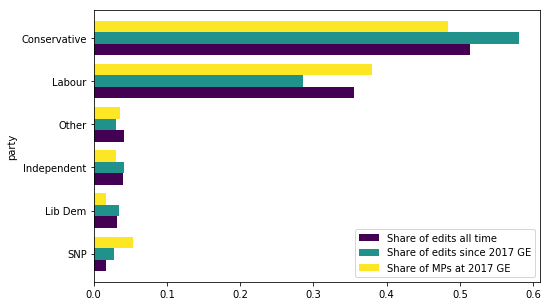

In [25]:
#Create new dataframe for plotting with all time edits, edits since 2017 and MP share
party_agg3 = party_agg2.merge(party_agg2b, left_index=True, right_index=True, how="outer")
party_agg3["Share of MPs at 2017 GE"] = np.array([314/650, 20/650, 247/650, 11/650, 23/650, 35/650])
party_agg3 = party_agg3.sort_values("Share of edits all time", ascending = True)

#Create chart
fig, ax = plt.subplots(figsize=(8,5))
party_agg3.plot.barh(ax=ax, colormap="viridis", width=0.8)
plt.savefig("figures/party")

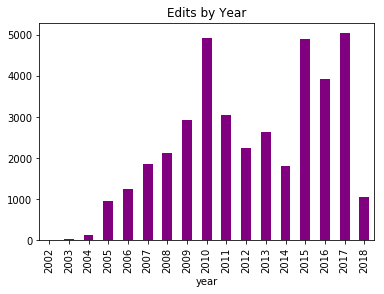

In [26]:
#Edits by year
wiki_edits_4["year"] = wiki_edits_4.Timestamp.apply(lambda x: x.year)
pd.Series(wiki_edits_4.groupby("year").size()).plot.bar(color="purple", title="Edits by Year" )
plt.savefig("figures/year")

## <a id="RQ2">RQ2<a/>

In [27]:
election_2017

ONS Code  Press association number   \
0    W07000049                          1   
1    W07000058                          2   
2    S14000001                          3   
3    S14000002                          4   
4    S14000003                          6   
5    E14000530                          7   
6    E14000531                          8   
7    E14000532                          9   
8    W07000043                         10   
9    E14000533                         11   
10   S14000004                         12   
11   W07000057                         16   
12   S14000005                         17   
13   E14000534                         18   
14   E14000535                         19   
15   E14000536                         20   
16   E14000537                         21   
17   E14000538                         22   
18   S14000006                         23   
19   E14000539                         26   
20   S14000007                         27   
21   E14000540                         28   
22   E14000541                         29   
23   E14000542                         30   
24   E14000543                         31   
25   E14000544                         32   
26   E14000545                         34   
27   E14000546                         35   
28   E14000547                         36   
29   E14000548                         37   
30   E14000549                         38   
31   E14000550                         39   
32   E14000551                         40   
33   E14000552                         41   
34   N06000001                         45   
35   N06000002                         46   
36   N06000003                         47   
37   N06000004                         48   
38   E14000553                         49   
39   S14000008                         51   
40   E14000554                         50   
41   E14000555                         52   
42   E14000556                         53   
43   E14000557                         54   
44   E14000558                         55   
45   E14000559                         56   
46   E14000560                         57   
47   E14000561                         58   
48   E14000562                         59   
49   E14000563                         60   
50   E14000564                         61   
51   E14000565                         62   
52   E14000566                         63   
53   E14000567                         64   
54   E14000568                         65   
55   E14000569                         66   
56   E14000570                         67   
57   E14000571                         68   
58   E14000572                         69   
59   E14000573                         70   
60   W07000072                         71   
61   E14000574                         72   
62   E14000575                         73   
63   E14000576                         74   
64   E14000577                         75   
65   E14000578                         76   
66   E14000579                         77   
67   E14000580                         78   
68   E14000581                         79   
69   E14000582                         80   
70   E14000583                         81   
71   E14000584                         82   
72   E14000585                         83   
73   E14000586                         84   
74   E14000587                         85   
75   E14000588                         86   
76   E14000589                         87   
77   E14000590                         88   
78   W07000068                         89   
79   E14000591                         90   
80   E14000592                         91   
81   E14000593                         92   
82   E14000594                         93   
83   W07000073                         94   
84   E14000595                         95   
85   E14000596                         96   
86   E14000597                         97   
87   E14000598                         98   
8

In [28]:
#Create aggregates for each constituency 

editor_constit_agg = pd.DataFrame(wiki_edits_4.groupby(by=["EditorConstituencyCode", "EditorConstituency", "reversion"]).count())
editor_constit_agg2 =pd.DataFrame(editor_constit_agg["mp"].sort_values(ascending=False))
editor_constit_agg2.columns = ["Edit_count"]
editor_constit_agg2 = editor_constit_agg2.reset_index()

#Create a new turnout frame with columns of interest
election_2017_2 = election_2017[["ONS Code", "Electorate ", "Valid vote turnout (all valid votes)"]]

election_2017_2.columns = ["EditorConstituencyCode", "electorate", "turnout"]

#Merge edit frame with votor turnout info                                       
editor_constit_agg2 = editor_constit_agg2.merge(election_2017_2, how="left")
editor_constit_agg2

#Add turnout data
editor_constit_agg2['turnout'] = editor_constit_agg2['turnout'].str.rstrip('%').astype('float') / 100.0

In [29]:
#Any edit type
editor_constit_agg2A = pd.DataFrame(editor_constit_agg2.groupby(["EditorConstituencyCode", "EditorConstituency", "turnout", "electorate"]).sum()).sort_values("Edit_count", ascending=False)
editor_constit_agg2A = editor_constit_agg2A.drop(columns=["reversion"])
editor_constit_agg2A = editor_constit_agg2A.reset_index()
editor_constit_agg2A['Edits_per_1000'] = editor_constit_agg2A["Edit_count"] / editor_constit_agg2A["electorate"] * 1000
editor_constit_agg2A.head(10)

EditorConstituencyCode                EditorConstituency  turnout  \
0              E14000789                Lewisham, Deptford    0.702   
1              E14000639  Cities of London and Westminster    0.628   
2              E14000630                        Cheltenham    0.724   
3              E14000873                       Oxford East    0.688   
4              E14000919                 Sheffield Central    0.618   
5              E14000549                         Battersea    0.710   
6              E14000777                     Leeds Central    0.532   
7              E14000807                Manchester Central    0.548   
8              E14001061                      York Central    0.689   
9              E14000718            Greenwich and Woolwich    0.688   

   electorate  Edit_count  Edits_per_1000  
0       78471        1106       14.094379  
1       61533         644       10.465929  
2       78724         561        7.126162  
3       78353         507        6.470716  
4       77560         365        4.706034  
5       77574         308        3.970402  
6       89537         295        3.294727  
7       90673         255        2.812304  
8       77315         237        3.065382  
9       77190         226        2.927840

In [30]:
#Just reversions
editor_constit_agg2B = editor_constit_agg2.loc[editor_constit_agg2["reversion"] == 1]
editor_constit_agg2B = pd.DataFrame(editor_constit_agg2B.groupby(["EditorConstituencyCode", "EditorConstituency", "turnout", "electorate"]).sum()).sort_values("Edit_count", ascending=False)
editor_constit_agg2B = editor_constit_agg2B.drop(columns=["reversion"])
editor_constit_agg2B = editor_constit_agg2B.reset_index()
editor_constit_agg2B['Edits_per_1000'] = editor_constit_agg2B["Edit_count"] / editor_constit_agg2B["electorate"] * 1000
editor_constit_agg2B.head(10)

EditorConstituencyCode                EditorConstituency  turnout  \
0              E14000789                Lewisham, Deptford    0.702   
1              E14000639  Cities of London and Westminster    0.628   
2              E14000873                       Oxford East    0.688   
3              E14000549                         Battersea    0.710   
4              E14000919                 Sheffield Central    0.618   
5              E14000777                     Leeds Central    0.532   
6              E14000718            Greenwich and Woolwich    0.688   
7              E14000630                        Cheltenham    0.724   
8              E14000764      Islington South and Finsbury    0.691   
9              E14000978                         Streatham    0.709   

   electorate  Edit_count  Edits_per_1000  
0       78471         487        6.206114  
1       61533         186        3.022768  
2       78353         153        1.952701  
3       77574         139        1.791837  
4       77560         109        1.405364  
5       89537         100        1.116857  
6       77190          85        1.101179  
7       78724          72        0.914588  
8       69547          68        0.977756  
9       78649          66        0.839172

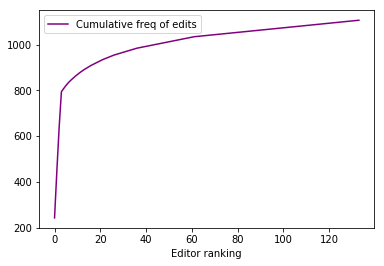

In [31]:
lewisham = wiki_edits_4.loc[wiki_edits_4.EditorConstituency == "Lewisham, Deptford" ].groupby(["User", "reversion"]).size().reset_index(name='Edit_count').sort_values("Edit_count", ascending=False).reset_index()
lewisham["Cumulative freq of edits"] = lewisham["Edit_count"].cumsum()
ax = lewisham.plot(y="Cumulative freq of edits", color="purple")
ax.set_xlabel("Editor ranking")
plt.savefig("figures/lewisham")

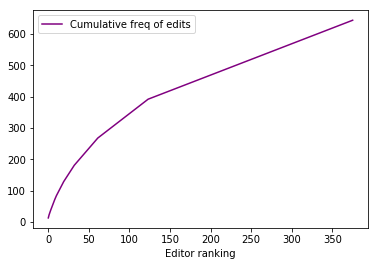

In [32]:
west_city = wiki_edits_4.loc[wiki_edits_4.EditorConstituency == "Cities of London and Westminster" ].groupby(["User", "reversion"]).size().reset_index(name='Edit_count').sort_values("Edit_count", ascending=False).reset_index()

west_city["Cumulative freq of edits"] = west_city["Edit_count"].cumsum()
ax = west_city.plot(y="Cumulative freq of edits", color="purple")
ax.set_xlabel("Editor ranking")
plt.savefig("figures/west-city")

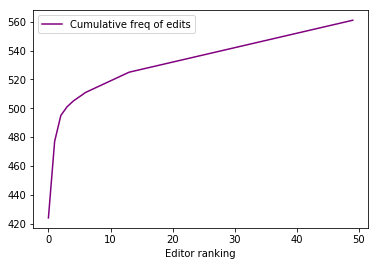

In [33]:
cheltenham = wiki_edits_4.loc[wiki_edits_4.EditorConstituency == "Cheltenham" ].groupby(["User", "reversion"]).size().reset_index(name='Edit_count').sort_values("Edit_count", ascending=False).reset_index()

cheltenham["Cumulative freq of edits"] = cheltenham["Edit_count"].cumsum()
cheltenham
ax = cheltenham.plot(y="Cumulative freq of edits", color="purple")
ax.set_xlabel("Editor ranking")
plt.savefig("figures/cheltenham")

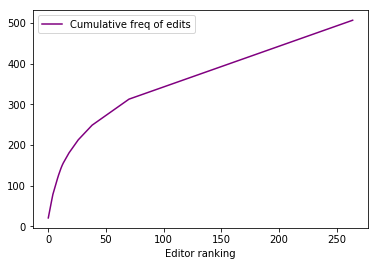

In [34]:
oxford_east = wiki_edits_4.loc[wiki_edits_4.EditorConstituency == "Oxford East" ].groupby(["User", "reversion"]).size().reset_index(name='Edit_count').sort_values("Edit_count", ascending=False).reset_index()

oxford_east["Cumulative freq of edits"] = oxford_east["Edit_count"].cumsum()
ax = oxford_east.plot(y="Cumulative freq of edits", color="purple")
ax.set_xlabel("Editor ranking")
plt.savefig("figures/oxford_east")

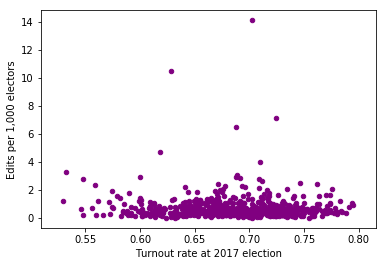

In [35]:
#Plotting turnout rate and editing intensity
ax = editor_constit_agg2A.plot.scatter(x="turnout", y="Edits_per_1000", color="purple")
ax.set_xlabel("Turnout rate at 2017 election")
ax.set_ylabel("Edits per 1,000 electors")
plt.savefig("figures/turnout")

In [36]:
#Correlation coefficient
scipy.stats.pearsonr(editor_constit_agg2A.Edits_per_1000, editor_constit_agg2A.turnout)

(-0.05340533959651861, 0.1758612345617446)

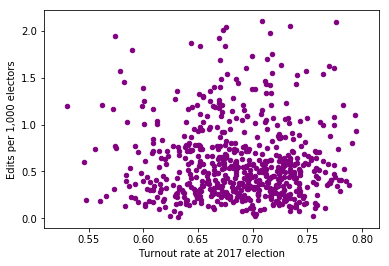

In [37]:
#Exclude strong outliers
median = editor_constit_agg2A["Edits_per_1000"].quantile(0.5)
UQ = editor_constit_agg2A["Edits_per_1000"].quantile(0.75)
LQ = editor_constit_agg2A["Edits_per_1000"].quantile(0.25)
IQR = UQ - LQ
outlier_limit =  UQ + 3.0*IQR
ax = editor_constit_agg2A.loc[editor_constit_agg2A.Edits_per_1000 < outlier_limit].plot.scatter(x="turnout", y="Edits_per_1000", color="purple")
ax.set_xlabel("Turnout rate at 2017 election")
ax.set_ylabel("Edits per 1,000 electors")
plt.savefig("figures/turnoutX")

## <a id="RQ3">RQ3<a/>

In [38]:
#Create geodataframe with editor constituency aggregates

editor_constit_agg3 = pd.DataFrame(wiki_edits_4.groupby(by=["EditorConstituencyCode", "EditorConstituency"]).count())

#Timestamp column populated from previous step with edit count
editor_constit_agg3 = editor_constit_agg3[["Timestamp"]]
editor_constit_agg3.columns = ["Edit_count"]


editor_constit_agg_geo = constit_bounds.merge(editor_constit_agg3, right_on="EditorConstituencyCode", left_on="pcon17cd", how="outer")
editor_constit_agg_geo

#Change nan values to 0
editor_constit_agg_geo = editor_constit_agg_geo.fillna(0)

#Change CRS
editor_constit_agg_geo = editor_constit_agg_geo.to_crs(epsg=3857)

In [39]:
editor_constit_agg_geo.sort_values("Edit_count", ascending=False).reset_index()

index   pcon17cd                                     pcon17nm   bng_e  \
0      132  E14000789                           Lewisham, Deptford  537339   
1       93  E14000639             Cities of London and Westminster  528186   
2       85  E14000630                                   Cheltenham  394670   
3      326  E14000873                                  Oxford East  453747   
4      397  E14000919                            Sheffield Central  435726   
5       24  E14000549                                    Battersea  527493   
6      256  E14000777                                Leeds Central  431014   
7      277  E14000807                           Manchester Central  386354   
8      538  E14001061                                 York Central  459887   
9      198  E14000718                       Greenwich and Woolwich  541975   
10     446  E14000978                                    Streatham  530188   
11     579  S14000023                    Edinburgh North and Leith  324819   
12      91  E14000615                       Camberwell and Peckham  533978   
13     415  E14000934                         South Cambridgeshire  537837   
14     225  E14000764                 Islington South and Finsbury  531411   
15     150  E14000674                     Ealing Central and Acton  519016   
16     378  E14000904                                    Rotherham  442371   
17     411  E14000933             South Basildon and East Thurrock  568418   
18     221  E14000763                              Islington North  530598   
19      48  E14000760                                 Ilford South  544661   
20     401  E14000922                            Sheffield, Hallam  426415   
21     585  S14000029                              Glasgow Central  257847   
22     265  E14000787                                Lewisham East  538644   
23      75  E14000602                                 Bristol West  359407   
24     238  E14000750                      Holborn and St. Pancras  529119   
25     353  E14000880               Plymouth, Sutton and Devonport  247629   
26     517  E14001036                            Westminster North  525949   
27     185  E14000703                   Finchley and Golders Green  525192   
28     341  E14000867                             Nottingham South  454681   
29     145  E14000790                          Leyton and Wanstead  539833   
30     130  E14000654                              Croydon Central  535759   
31     471  E14000990                                   Tewkesbury  395051   
32     436  E14000955                          Southampton, Itchen  445458   
33     281  E14000809                       Manchester, Withington  384007   
34     241  E14000753                                      Horsham  516728   
35     270  E14000794                            Liverpool, Walton  336910   
36      35  E14000564                         Birmingham, Ladywood  407075   
37     474  E14001008                                     Vauxhall  530310   
38     294  E14000821                          Milton Keynes North  486764   
39       8  E14000538                                    Aylesbury  482160   
40     229  E14000773           Kingston upon Hull West and Hessle  507415   
41     176  E14000697                             Esher and Walton  513123   
42      71  E14000598                           Brighton, Pavilion  531231   
43     576  S14000025                         Edinburgh South West  318312   
44     206  E14000726                                  Hammersmith  523262   
45     615  W07000044                                      Wrexham  336339   
46     466  E14001002                                    Tottenham  532898   
47     193  E14000708                         Garston and Halewood  343589   
48     282  E14000804                      Maidstone and The Weald  575796   
49     271  E14000795                         Liverpool, Wavertree  339023   
50     620  W07000051      

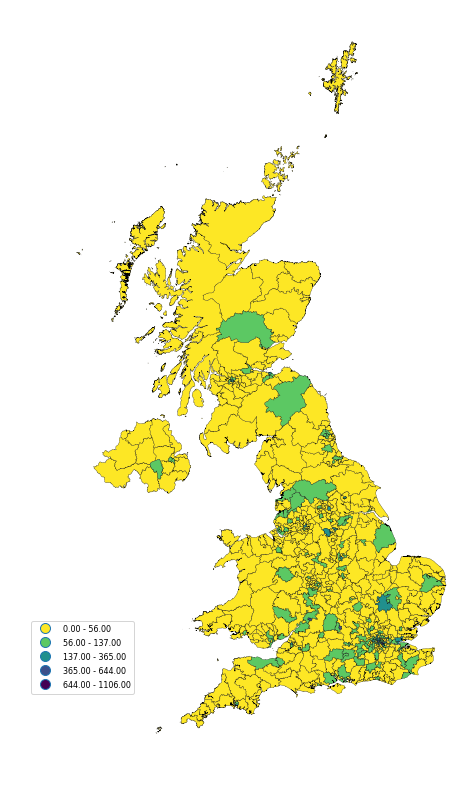

In [40]:
#Chloropleth map editor constituency

cmap = cm.viridis
cmap_r = cmap.reversed()

ax2 = editor_constit_agg_geo.plot(column="Edit_count", scheme='fisher_jenks', alpha=1, k=5, \
         cmap=cmap_r, 
         edgecolor='black', linewidth=0.25, figsize=(10, 14), legend=True)

plt.axis('off')

leg = ax2.get_legend()
leg.get_texts()[0].set_fontsize('8')
leg.set_bbox_to_anchor((0., 0., 0.2, 0.2))

plt.savefig("figures/EditorChlor")

In [41]:
const_hex1 = const_hex["hexes"]

const_hex_dict = {}
for key in const_hex1:
    const_hex_dict[key] = [const_hex1[key]['q'], const_hex1[key]['r']]
const_hex3 = pd.DataFrame.from_dict(const_hex_dict).T
const_hex3.columns = ["X", "Y"]

print(const_hex3.Y.min())
print(const_hex3.Y.max())
print(const_hex3.X.min())
print(const_hex3.X.max())

-17
28
-17
13


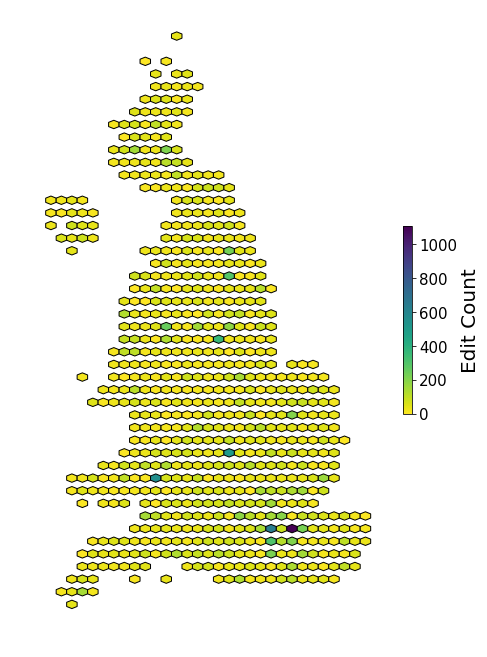

In [42]:
#Map of number of edits by constituency of editor

editor_constit_agg_geo2 = editor_constit_agg_geo.merge(const_hex3, left_on="pcon17cd", right_index=True)

f, ax = plt.subplots(figsize=(7.75,11.5))

cmap = cm.viridis
cmap_r = cmap.reversed()

# Add hexagon layer that displays count of points in each polygon
hb = ax.hexbin(editor_constit_agg_geo2.X, editor_constit_agg_geo2.Y, C=editor_constit_agg_geo2["Edit_count"], gridsize=(30,45), alpha=1, cmap=cmap_r, edgecolors="black", mincnt=0)

plt.axis('off')

#Add colorbar
cb = plt.colorbar(hb, shrink=0.3)
cb.set_label(label='Edit Count',size=20)
cb.ax.tick_params(labelsize=15)


plt.savefig("figures/Editorhex")

In [43]:
#Global spatial autocorrelation
W1 = ps.weights.Queen.from_dataframe(editor_constit_agg_geo)
mi1 = esda.moran.Moran(editor_constit_agg_geo.Edit_count, W1) # call moran function
mi1.I # print out the moran's I value

('WARNING: ', 217, ' is an island (no neighbors)')
('WARNING: ', 583, ' is an island (no neighbors)')
('WARNING: ', 601, ' is an island (no neighbors)')
('WARNING: ', 610, ' is an island (no neighbors)')


/Users/student/anaconda3/envs/cusplondon/lib/python3.6/site-packages/pysal/weights/weights.py:189: UserWarning: There are 4 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/Users/student/anaconda3/envs/cusplondon/lib/python3.6/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 217, 583, 601, 610
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


0.1421874602138745

/Users/student/anaconda3/envs/cusplondon/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/Users/student/anaconda3/envs/cusplondon/lib/python3.6/site-packages/pysal/weights/weights.py:189: UserWarning: There are 4 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/Users/student/anaconda3/envs/cusplondon/lib/python3.6/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 217, 583, 601, 610
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


('WARNING: ', 217, ' is an island (no neighbors)')
('WARNING: ', 583, ' is an island (no neighbors)')
('WARNING: ', 601, ' is an island (no neighbors)')
('WARNING: ', 610, ' is an island (no neighbors)')


/Users/student/anaconda3/envs/cusplondon/lib/python3.6/site-packages/pysal/esda/moran.py:851: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/Users/student/anaconda3/envs/cusplondon/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/student/anaconda3/envs/cusplondon/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/student/anaconda3/envs/cusplondon/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


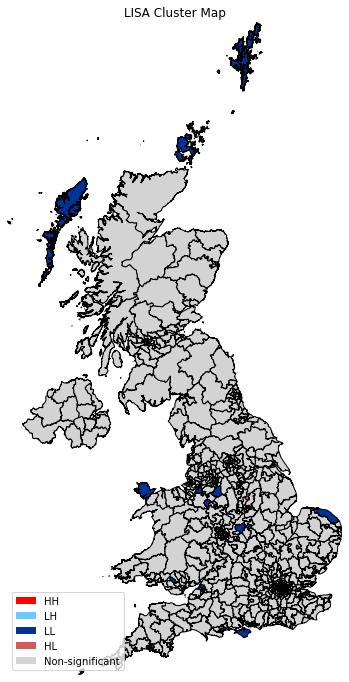

In [44]:
#LISA plot constituency of editor
editor_constit_agg_geo.to_file(driver='ESRI Shapefile', filename="data/exp1.shp")
w_queen = ps.weights.Queen.from_dataframe(editor_constit_agg_geo)
lisa = ps.Moran_Local(editor_constit_agg_geo['Edit_count'].values, w_queen, permutations=999)

data="data/exp1.shp"
viz.plot_lisa_cluster(data,lisa, title="LISA Cluster Map", figsize=(6,12), leg_loc=3, savein="figures/editor_moran.png")

In [45]:
#Geo dataframe for edits by MP chloropleth
constit_MP_agg_geo = constit_bounds.merge(MP_agg2, right_on="mpConstituency", left_on="pcon17nm", how="outer")

constit_MP_agg_geo = constit_MP_agg_geo.to_crs(epsg=3857).sort_values(by="Edit_count", ascending=False)
constit_MP_agg_geo = constit_MP_agg_geo.fillna(0)
constit_MP_agg_geo

pcon17cd                                     pcon17nm   bng_e   bng_n  \
473  E14001007                   Uxbridge and South Ruislip  508041  183856   
151  E14000669                              Doncaster North  455325  408912   
91   E14000615                       Camberwell and Peckham  533978  176264   
454  E14000983                                 Surrey Heath  493294  162147   
110  E14000634                 Chingford and Woodford Green  538751  192824   
280  E14000803                                   Maidenhead  484373  178129   
201  E14000720            Hackney North and Stoke Newington  533597  186241   
485  E14001005                                   Twickenham  514896  171607   
82   E14000608                                   Buckingham  477472  222419   
49   E14000577                                     Bolsover  447998  366869   
507  E14001027                              Welwyn Hatfield  525345  208467   
374  E14000896                                Richmond Park  519834  173049   
221  E14000763                              Islington North  530598  186352   
334  E14000850                               North Somerset  347309  169216   
140  E14000663                                  Derby South  436265  333095   
384  E14000908                                   Rushcliffe  462332  332669   
330  E14000846                          North East Somerset  364116  161999   
446  E14000978                                    Streatham  530188  172431   
639  W07000065                        Preseli Pembrokeshire  193261  226426   
291  E14000813                             Mid Bedfordshire  504718  239346   
465  E14000987                                       Tatton  372677  375936   
261  E14000782                               Leicester East  461961  305445   
204  E14000724                       Haltemprice and Howden  488260  432100   
225  E14000764                 Islington South and Finsbury  531411  183491   
215  E14000735                             Hastings and Rye  586062  116890   
314  E14000836         Normanton, Pontefract and Castleford  447021  422148   
173  E14000694                              Epsom and Ewell  520890  161165   
146  E14000667                                   Don Valley  460102  396080   
504  E14001025                               Wellingborough  491876  265617   
511  E14001031                                  West Dorset  357765   99663   
518  E14001037                     Westmorland and Lonsdale  352958  492385   
256  E14000777                                Leeds Central  431014  431345   
64   E14000591                                Brent Central  521541  185236   
377  E14000900                                      Romford  551408  190670   
404  E14000925                                      Shipley  412611  439633   
371  E14000907                      Runnymede and Weybridge  503012  166624   
271  E14000795                         Liverpool, Wavertree  339023  390195   
509  E14001029                           West Bromwich East  402098  293072   
263  E14000784                               Leicester West  456222  306111   
466  E14001002                                    Tottenham  532898  189292   
414  E14000942                       South Northamptonshire  463454  246589   
13   E14000540                                      Barking  546099  184533   
385  E14000909                           Rutland and Melton  484648  311819   
20   E14000546                                    Bassetlaw  469769  385125   
106  E14000676                             Ealing, Southall  514022  180335   
536  N06000002                                Belfast North  145236  534734   
260  E14000781                                   Leeds West  425371  433988   
621  W07000052                                      Rhondda  296949  196169   
71   E14000598                           Brighton, Pavilion  531231  107528   
6    E14000536                                      Ashf

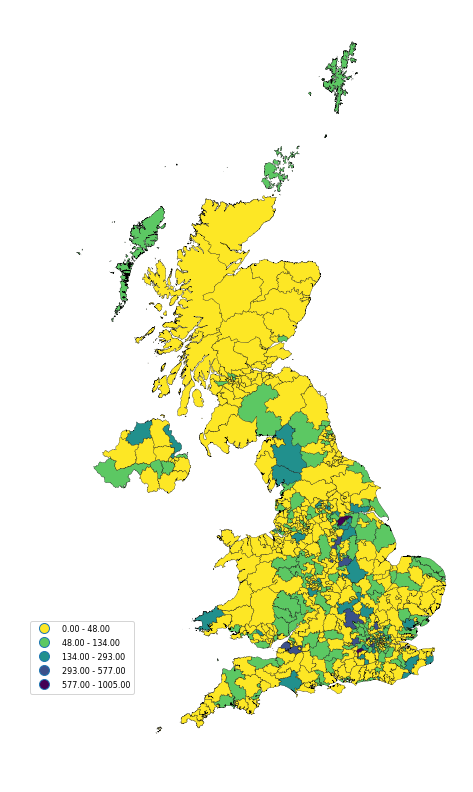

In [46]:
#Chloropleth constituency of MP
cmap = cm.viridis
cmap_r = cmap.reversed()

ax2 = constit_MP_agg_geo.plot(column="Edit_count", scheme='fisher_jenks', alpha=1, k=5, \
         cmap=cmap_r, 
         edgecolor='black', linewidth=0.25, figsize=(10, 14), legend=True)

plt.axis('off')

leg = ax2.get_legend()
leg.get_texts()[0].set_fontsize('8')
leg.set_bbox_to_anchor((0., 0., 0.2, 0.2))

plt.savefig("figures/MPChlor")

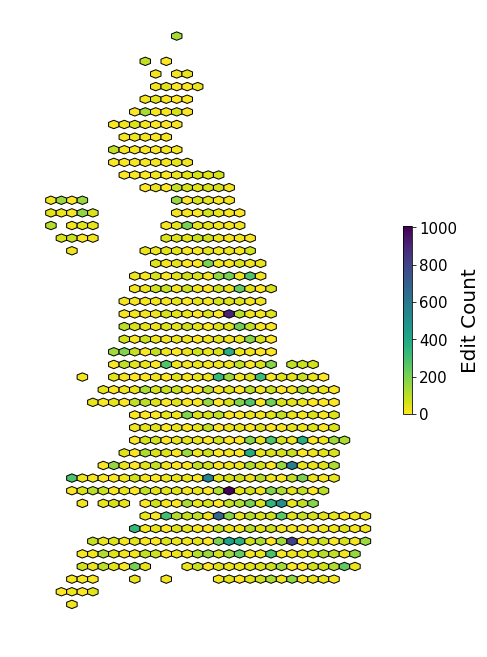

In [47]:
#Map of number of edits by constituency of MP

constit_MP_agg_geo2 = constit_MP_agg_geo.merge(const_hex3, left_on="pcon17cd", right_index=True)

f, ax = plt.subplots(figsize=(7.75,11.5))

cmap = cm.viridis
cmap_r = cmap.reversed()

# Add hexagon layer that displays count of points in each polygon
hb = ax.hexbin(constit_MP_agg_geo2.X, constit_MP_agg_geo2.Y, C=constit_MP_agg_geo2["Edit_count"], gridsize=(30,45), alpha=1, cmap=cmap_r, edgecolors="black", mincnt=0)

plt.axis('off')

#Add colorbar
cb = plt.colorbar(hb, shrink=0.3)
cb.set_label(label='Edit Count', size=20)
cb.ax.tick_params(labelsize=15)

plt.savefig("figures/MPhex")

In [48]:
#Global spatial autocorrelation
W = ps.weights.Queen.from_dataframe(constit_MP_agg_geo)
mi = esda.moran.Moran(constit_MP_agg_geo.Edit_count, W) # call moran function
mi.I # print out the moran's I value

('WARNING: ', 601, ' is an island (no neighbors)')
('WARNING: ', 583, ' is an island (no neighbors)')
('WARNING: ', 610, ' is an island (no neighbors)')
('WARNING: ', 217, ' is an island (no neighbors)')


/Users/student/anaconda3/envs/cusplondon/lib/python3.6/site-packages/pysal/weights/weights.py:189: UserWarning: There are 4 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/Users/student/anaconda3/envs/cusplondon/lib/python3.6/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 601, 583, 610, 217
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


0.044795150533659706

/Users/student/anaconda3/envs/cusplondon/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
/Users/student/anaconda3/envs/cusplondon/lib/python3.6/site-packages/pysal/weights/weights.py:189: UserWarning: There are 4 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/Users/student/anaconda3/envs/cusplondon/lib/python3.6/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 601, 583, 610, 217
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


('WARNING: ', 601, ' is an island (no neighbors)')
('WARNING: ', 583, ' is an island (no neighbors)')
('WARNING: ', 610, ' is an island (no neighbors)')
('WARNING: ', 217, ' is an island (no neighbors)')


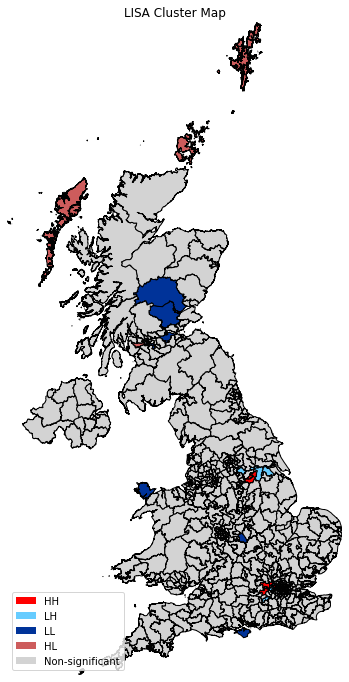

In [49]:
#LISA plot constituency of MP
constit_MP_agg_geo.to_file(driver='ESRI Shapefile', filename="data/exp2.shp")
w_queen = ps.weights.Queen.from_dataframe(constit_MP_agg_geo)
lisa = ps.Moran_Local(constit_MP_agg_geo['Edit_count'].values, w_queen, permutations=999)

data="data/exp2.shp"
viz.plot_lisa_cluster(data,lisa, title="LISA Cluster Map", figsize=(6,12), leg_loc=3, savein="figures/MP_moran.png")

## <a id="RQ4">RQ4<a/>

In [50]:
#How often does editing constituency match MP constituency?

x = wiki_edits_4.loc[wiki_edits_4["reversion"]==0]

print(x["MATCH"].sum()/len(x))

y = wiki_edits_4.loc[wiki_edits_4["reversion"]==1]

print(y["MATCH"].sum()/len(y))

0.015485040797824116
0.016129032258064516


In [51]:
#Total edits where constituency of editor matches constituency of MP
wiki_edits_4["MATCH"].sum()

611

In [52]:
#Binomial test
scipy.stats.binom_test(611, n=34793, p=0.0015384615384615385)

0.0

In [53]:
#Edits grouped by IP address

wiki_edits_4b = wiki_edits_4.dropna(subset=['EditorConstituency'])

editor_agg = (wiki_edits_4b.groupby('User')['MP Name']
       .apply(lambda x: list((x)))
       .reset_index())

editor_agg["Edit count"] = editor_agg["MP Name"].apply(lambda x: len(x))
editor_agg = editor_agg.sort_values("Edit count", ascending=False)
editor_agg 

User  \
5155                             77.97.175.220 (talk)   
2047                              194.60.38.10 (talk)   
2048                             194.60.38.198 (talk)   
7576                              81.23.57.177 (talk)   
2204                            195.171.221.67 (talk)   
5154                               77.97.174.2 (talk)   
13175                             88.98.85.216 (talk)   
1047                             144.32.240.58 (talk)   
6109                               80.2.141.56 (talk)   
13661                           90.202.217.125 (talk)   
9187                              84.92.117.93 (talk)   
13797                             90.208.42.36 (talk)   
9408                               86.11.54.53 (talk)   
15649                              94.3.123.54 (talk)   
9850                             86.135.13.104 (talk)   
11072                           86.161.140.175 (talk)   
14776                            92.25.205.166 (talk)   
7582                              81.5.173.235 (talk)   
15504                            94.193.134.29 (talk)   
6617                             81.110.220.68 (talk)   
6563                              81.108.14.46 (talk)   
6184                             80.235.236.54 (talk)   
8686                              82.44.28.222 (talk)   
8835                              82.6.168.150 (talk)   
14674                             92.238.45.47 (talk)   
12817                            87.114.28.144 (talk)   
14666                           92.238.184.250 (talk)   
206                            109.153.104.163 (talk)   
5079                            77.103.147.111 (talk)   
11900                            86.180.92.117 (talk)   
12452                             86.3.127.116 (talk)   
9837                             86.135.10.119 (talk)   
3443                             217.41.240.15 (talk)   
6513                            81.106.116.168 (talk)   
9504                            86.129.158.107 (talk)   
3042                             213.105.80.22 (talk)   
7919                            82.153.197.211 (talk)   
9109                              84.13.22.210 (talk)   
14924                            92.30.130.232 (talk)   
6942                             81.144.235.66 (talk)   
11916                           86.181.231.191 (talk)   
4772                              51.7.251.153 (talk)   
12501                              86.31.253.5 (talk)   
11460                             86.170.87.52 (talk)   
4428                              31.52.11.103 (talk)   
2951                              212.161.4.84 (talk)   
5247                             78.144.252.52 (talk)   
13690                             90.203.62.17 (talk)   
14925                            92.30.132.159 (talk)   
2072                              194.60.38.60 (talk)   
6456                              81.102.86.57 (talk)   
14755                            92.25.194.187 (talk)   
10996                             86.159.157.5 (talk)   
641                               129.67.55.13 (talk)   
6538                            81.107.198.149 (talk)   
5888                              80.0.228.119 (talk)   
11869                             86.180.175.7 (talk)   
11347                             86.167.92.76 (talk)   
14141                           91.206.176.225 (talk)   
1272                             150.237.47.14 (talk)   
907                             138.253.48.190 (talk)   
8843                               82.6.52.193 (talk)   
7535                            81.178.238.231 (talk)   
5068                               77.102.93.4 (talk)   
1274                              150.237.47.3 (talk)   
11108                            86.162.103.24 (talk)   
14917                             92.30.111.99 (talk)   
6574                             81.108.237.86 (talk)   
9833                             86.134.96.218 (talk)   
14817                            92.27.124.124 (talk)   
34

In [54]:
#Zip two columns together
edit_mp = list(zip(editor_agg["User"], editor_agg["MP Name"]))

#New list of lists with IP address and single MP page edited
pairs = []
for i in range(len(edit_mp)): #for every element in big list
    for j in range(len(edit_mp[i][1])): #for every element in the sub list
        pairs.append([edit_mp[i][0], edit_mp[i][1][j]])

#Above as data frame       
MP_editor_pair = pd.DataFrame([list(zip(*pairs))[0], list(zip(*pairs))[1]]) .transpose()
MP_editor_pair.columns = ["User", "MP Name"]
MP_editor_pair = MP_editor_pair.set_index(["User", "MP Name"])
MP_editor_pair

#Add new frequency column       
MP_editor_pair["Edit count"] = 1

#Use group by to get get frequencies      
MP_editor_pair = MP_editor_pair.groupby(["User", "MP Name"]).sum().reset_index()

MP_editor_pair.sort_values("Edit count", ascending=False)

User  \
17690                          90.202.217.125 (talk)   
13080                           86.135.13.104 (talk)   
2667                             194.60.38.10 (talk)   
6901                            77.97.175.220 (talk)   
19975                           94.193.134.29 (talk)   
20138                             94.3.123.54 (talk)   
10231                            81.5.173.235 (talk)   
8398                            80.235.236.54 (talk)   
18962                          92.238.184.250 (talk)   
16620                           87.114.28.144 (talk)   
13065                           86.135.10.119 (talk)   
8806                           81.106.116.168 (talk)   
6254                             51.7.251.153 (talk)   
14963                            86.170.87.52 (talk)   
10599                          82.153.197.211 (talk)   
8741                             81.102.86.57 (talk)   
14393                            86.159.157.5 (talk)   
3203                           195.171.221.67 (talk)   
8834                           81.107.198.149 (talk)   
11796                             82.6.52.193 (talk)   
2707                             194.60.38.10 (talk)   
19318                            92.30.111.99 (talk)   
19328                           92.30.130.232 (talk)   
4708                            217.41.21.240 (talk)   
267                           109.153.210.183 (talk)   
17431                            90.194.17.96 (talk)   
2790                            194.60.38.198 (talk)   
2714                             194.60.38.10 (talk)   
17367                             90.152.7.58 (talk)   
11124                             82.32.72.87 (talk)   
9675                            81.154.37.178 (talk)   
2721                             194.60.38.10 (talk)   
15515                          86.181.231.191 (talk)   
18367                          91.206.177.129 (talk)   
1112                            137.73.160.27 (talk)   
18366                          91.206.176.225 (talk)   
13083                           86.135.13.191 (talk)   
10467                           82.12.115.218 (talk)   
20286                           95.144.21.216 (talk)   
19574                             92.8.108.30 (talk)   
7724                             79.66.214.40 (talk)   
8099                             80.176.79.37 (talk)   
2643                             194.60.38.10 (talk)   
2823                            194.60.38.198 (talk)   
3059                           194.74.177.198 (talk)   
12677                          86.129.158.107 (talk)   
18933                           92.237.23.242 (talk)   
2783                            194.60.38.198 (talk)   
1646                           149.254.58.249 (talk)   
1909                             163.1.127.94 (talk)   
7529                             78.149.22.75 (talk)   
10463                          82.118.116.193 (talk)   
18822                           92.233.116.20 (talk)   
14979                          86.171.166.106 (talk)   
11193                            82.35.140.68 (talk)   
16145                            86.3.127.116 (talk)   
248                           109.153.104.163 (talk)   
14087                           86.152.175.26 (talk)   
18965                            92.238.208.7 (talk)   
11094                             82.31.42.10 (talk)   
10689                           82.18.247.154 (talk)   
7383                            78.146.219.87 (talk)   
8759                              81.103.89.4 (talk)   
12676                          86.129.158.107 (talk)   
19359                            92.30.207.85 (talk)   
19609                             92.8.91.239 (talk)   
19332                           92.30.132.159 (talk)   
1658                            150.237.47.14 (talk)   
7418                           78.147.156.192 (talk)   
1669                            150.237.47.51 (talk)   
3115                             194.81.239.1 (talk)   
4107            

In [55]:
#Above as list of lists
listq = list(zip(MP_editor_pair["User"], MP_editor_pair["MP Name"], MP_editor_pair["Edit count"]))

#Unique editors
editor_set = set(list(zip(*pairs))[0])

#Unique MPs
MP_set = set(list(zip(*pairs))[1])

#Create graph
B = nx.Graph()

# Add nodes with the node attribute "bipartite"
B.add_nodes_from(editor_set, bipartite=0)
B.add_nodes_from(MP_set, bipartite=1)

# Add edges only between nodes of opposite node sets
B.add_weighted_edges_from(listq)

In [56]:
#Average degree of MP
degree = np.array(B.degree(MP_set))[:,1:].astype(float)
np.mean(degree)

33.43066884176183

In [57]:
#Max degree of MP
degree = np.array(B.degree(MP_set))[:,1:].astype(float)
np.max(degree)

517.0

In [58]:
#Average Degree of editor
degree = np.array(B.degree(editor_set))[:,1:].astype(float)
np.mean(degree)

1.2837812441270438

In [59]:
#Max Degree of editor
degree = np.array(B.degree(editor_set))[:,1:].astype(float)
np.max(degree)

362.0

In [60]:
#Function to extract coordinates
def extract_coords(point):
    lat = re.findall(r'[-]*[0-9]+[.]*[0-9]+', str(point))
    long = re.findall(r'\s([0-9]+[.]*[0-9]+)', str(point))
    return (float(lat[0]), float(long[0]))

In [61]:
#Function to convert CRS
inProj = Proj(init='epsg:3857')
outProj = Proj(init='epsg:27700')

def convert_bng(coords):
    return transform(inProj,outProj,coords[0],coords[1])

In [62]:
#Get centroid of MP constituencies
MP_geo = pd.DataFrame(wiki_edits_4.groupby(["MP Name","mpConstituency"])["Timestamp"].count())
MP_geo = MP_geo.reset_index().drop("Timestamp", axis=1)
MP_geo.columns = ["MP Name", "mpConstituency"]
MP_geo = pd.merge(MP_geo, constit_bounds, left_on= "mpConstituency", right_on= "pcon17nm" )
MP_geo = gpd.GeoDataFrame(MP_geo)
MP_geo["centroid"] = MP_geo.centroid
MP_geo
MP_geo = MP_geo[["MP Name", "centroid"]]
MP_geo["centroid"] = MP_geo["centroid"].apply(extract_coords)
MP_geo_dict = dict(zip(MP_geo["MP Name"], MP_geo["centroid"]))

In [63]:
#Get centroid of editor constituencies
editor_geo = pd.DataFrame(wiki_edits_4.groupby(["User","EditorConstituencyCode"])["Timestamp"].count())
editor_geo = editor_geo.reset_index().drop("Timestamp", axis=1)
editor_geo.columns = ["User", "EditorConstituencyCode"]
editor_geo = pd.merge(editor_geo, constit_bounds, left_on= "EditorConstituencyCode", right_on= "pcon17cd" )
editor_geo = gpd.GeoDataFrame(editor_geo)
editor_geo["centroid"] = editor_geo.centroid
editor_geo = editor_geo[["User", "centroid"]]
editor_geo["centroid"] = editor_geo["centroid"].apply(extract_coords)
editor_geo_dict = dict(zip(editor_geo["User"], editor_geo["centroid"]))

In [64]:
#Create new data frame with BNG coordiantes of centroid for MP constituency and editor constituency
User_MP_Geo = pd.DataFrame(listq, columns=["User", "MP Name", "Count"])
User_MP_Geo = User_MP_Geo.merge(wiki_edits_4[["User", "EditorConstituencyCode"]])
User_MP_Geo = User_MP_Geo.merge(MP_geo)
User_MP_Geo = User_MP_Geo.merge(MP_info4[["mpConstituency", "MP Name"]])
editor_geo.columns = ["User", "editor_centroid"]
User_MP_Geo = User_MP_Geo.merge(editor_geo)
User_MP_Geo["centroid"] = User_MP_Geo["centroid"].apply(convert_bng)
User_MP_Geo["editor_centroid"] = User_MP_Geo["editor_centroid"].apply(convert_bng)

In [65]:
#Function to calculate euclidean distance
def euc_dist(row):
    return np.sqrt( (row["centroid"][0] - row["editor_centroid"][0])**2
                           + (row["centroid"][1] - row["editor_centroid"][1])**2 )

User_MP_Geo['dist'] = User_MP_Geo.apply(euc_dist, axis=1)


In [66]:
#Weighted average distance function
def wavg(group, avg_name, weight_name):

    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

In [67]:
#Calculate weighted average distance between centroids
wavg(User_MP_Geo, "dist", "Count")

164112.93348466593

In [68]:
#Add distance information as edge attribute to graph
User_MP_Geo["edge"] = list(zip(User_MP_Geo.User, User_MP_Geo["MP Name"]))

User_MP_Geo_list = list(zip(User_MP_Geo.edge, User_MP_Geo["dist"]))

User_MP_Geo_dict = {}
for x in User_MP_Geo_list:
    User_MP_Geo_dict[x[0]] = {"Dist": x[1]}
User_MP_Geo_dict

nx.set_edge_attributes(B, User_MP_Geo_dict, name=None)

In [69]:
#Function from https://geopandas.readthedocs.io/en/latest/gallery/plotting_basemap_background.html
def add_basemap(ax, zoom, url='http://tile.stamen.com/toner/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

/Users/student/anaconda3/envs/cusplondon/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


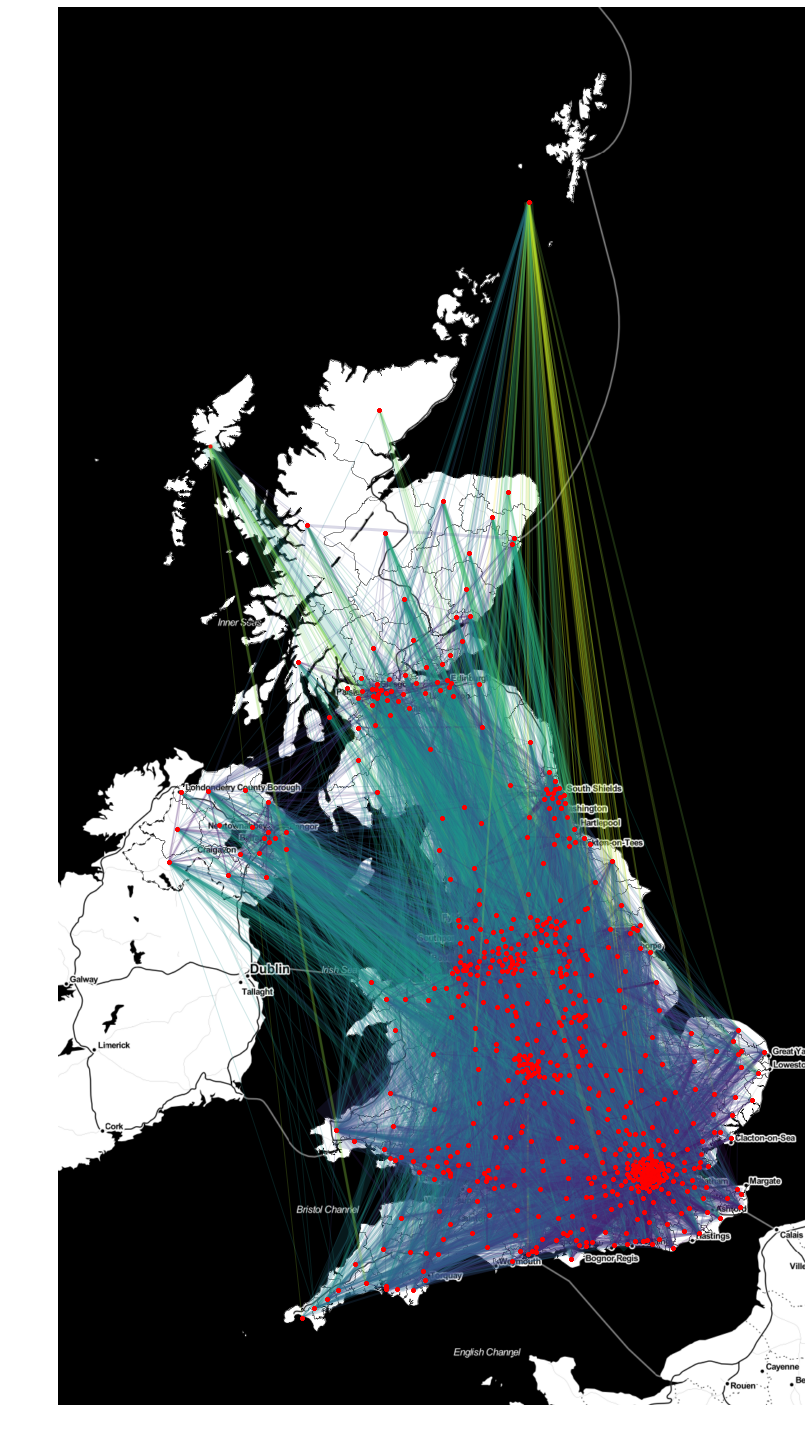

In [70]:
#Combined dictionary of editor and MP nodes
res = {**editor_geo_dict, **MP_geo_dict}

#Get weights from edge attributes
weight = np.array(list((nx.get_edge_attributes(B, "weight")).values()))
weight = weight.astype(float)

cmap2=plt.cm.Oranges

colors = list((nx.get_edge_attributes(B, "Dist")).values())

#Plot constituency boundaries
ax5 = constit_bounds.plot(edgecolor='black', linewidth=0.25, figsize=(20, 20), legend=True, facecolor="none")

#Plot nodes
nx.draw_networkx_nodes(G = B, pos = res, node_list = B.nodes(),node_color = "red", alpha = 0.8, node_size = 10)

#Plot edges
nx.draw_networkx_edges(G = B, pos = res, edge_color=colors, width= weight, alpha=0.2, arrows = True, cmap=cmap2)

add_basemap(ax5, zoom=7)

plt.tight_layout()
plt.axis('off')
plt.savefig("figures/edit-MP")